# Preliminaries

We will use the BIDSLayout library to help navigate MRI data. We will also some single-frame MRI data for examples on how to segment.

In [1]:
from bids import BIDSLayout
import pylab as plt
import numpy as np
import cv2

#%matplotlib notebook
%matplotlib inline

# Vectorized Marching Squares
This takes our implementation from class and uses the advantage of knowing that an MRI slice is a 2D image of pixels to speed it up by a factor of 8.

In [2]:
# Similar to class version of getContourCase, but does it for entire image at once.
def vec_getContourCase(thresh, cells):
    H, W = cells.shape

    result = np.zeros((cells.shape), 'int')
    mask = (cells >= thresh).astype('int')

    # Now mask[i, j] = 1 if cells[i, j] >= thresh
    # We will create three more masks
        # MaskS[i, j] = 1 if cells[i + 1, j] >= thresh
        # MaskE[i, j] = 1 if cells[i   , j + 1] >= thresh
        # MaskSE[i, j] = 1 if cells[i + 1, j + 1] >= thresh

    MaskS = np.zeros(mask.shape, mask.dtype)
    MaskE = np.zeros(mask.shape, mask.dtype)
    MaskSE = np.zeros(mask.shape, mask.dtype)
    MaskS[0:H-1] = mask[1:H,]
    MaskE[:, 0:W-1] = mask[:, 1:W]
    MaskSE[0:H-1, 0:W-1] = mask[1:H, 1:W]

    result = 8*mask + 4*MaskE + 2*MaskSE + MaskS
    return result

In [3]:
# Similar to class version of getCellSegments, but does it for entire image at once
def vec_getCellSegments(thresh, cells):
    
    H, W = cells.shape
    
    # instead of iterating through each cell
    #  and going through a series of if/else to test cases
    #  we'll compute all 8 cases simulatanously and then 
    #  take the right result from each of the 8 cases

    cases = vec_getContourCase(thresh, cells)

    # AFter this runs, 
    #  E[i, j] will contain the values of cells directy to the east of cells[i, j]
    #   (ie cells[i, j + 1])
    #  S[i, j] will contain directly to the south
    #  SE[i, j] will contain directly to the southeast.
    E = np.zeros(cells.shape)
    S = np.zeros(cells.shape)
    SE = np.zeros(cells.shape)
    I, J = np.mgrid[0:H, 0:W]
    E[:, 0:W-1] = cells[:, 1:W]
    S[0:H-1, :] = cells[1:H]
    SE[0:H-1, 0:W-1] = cells[1:H, 1:W]

    # Next we interpolate across the 4 sides of the pixel
    #  I_N_S is an interpolation between the N and S points
    #  I_E_SE is an interpolation between the E and SE points
    #  and so on
    with np.errstate(divide='ignore'):
        I_N_S  = I + interpolate(cells, S, thresh)
        I_E_SE = I + interpolate(E, SE, thresh)
        J_S_SE = J + interpolate(S, SE, thresh)
        J_N_E  = J + interpolate(cells, E, thresh)

    # We create a HxW vector that has all 8 possible line beginnings and ends
    #  This is to just to make case handling clearer
    all_p   = np.zeros((cells.shape[0], cells.shape[1], 8))
    all_p[:, :, 0] = I
    all_p[:, :, 1] = I + 1
    all_p[:, :, 2] = I_N_S
    all_p[:, :, 3] = I_E_SE

    all_p[:, :, 4] = J
    all_p[:, :, 5] = J + 1
    all_p[:, :, 6] = J_N_E
    all_p[:, :, 7] = J_S_SE

    # These are placeholders--we will store the line segment for each cell in here
    #   lines[i, j, :] = (y1, x1, y2, x2) corresponding to line segment (y1,x1)-(y2,x2)
    # lines2 is overfill for case 5 and 10
    lines   = np.zeros((cells.shape[0], cells.shape[1], 4))
    lines2  = np.zeros((cells.shape[0], cells.shape[1], 4))

    def helper2(lines, mask, i1, i2, i3, i4):
        lines[mask, 0] = all_p[mask, i1]
        lines[mask, 1] = all_p[mask, i2]
        lines[mask, 2] = all_p[mask, i3]
        lines[mask, 3] = all_p[mask, i4]

    # Set the appropriate line start and stop based on the case
    helper2(lines, np.logical_or(cases == 1, cases == 14), 2, 4, 1, 7)
    helper2(lines, np.logical_or(cases == 2, cases == 13), 1, 7, 3, 5)
    helper2(lines, np.logical_or(cases == 3, cases == 12), 2, 4, 3, 5)
    helper2(lines, np.logical_or(cases == 4, cases == 11), 0, 6, 3, 5)
    helper2(lines,               cases == 5              , 2, 4, 0, 6)
    helper2(lines2,              cases == 5              , 1, 7, 3, 5)
    helper2(lines, np.logical_or(cases == 6, cases ==  9), 0, 6, 1, 7)
    helper2(lines, np.logical_or(cases == 7, cases ==  8), 2, 4, 0, 6)
    helper2(lines,               cases == 10             , 2, 4, 1, 7)
    helper2(lines2,              cases == 10             , 0, 6, 3, 5)

    # Now we will just extract all the non-0 and non-15 cases
    #   The original algorithm goes by top-left--which means that the cells in the right most column 
    #    and bottom most rows don't get skipped.   There is an adjustment ot N for that
    mask = np.logical_and(I < H - 1, J < W - 1)
    N = np.sum( np.logical_and(cases[mask] > 0, cases[mask] < 15) ) + \
        np.sum( np.logical_or(cases[mask] == 5, cases[mask] == 10) )
    
    result = np.zeros((N, 4))
    
    ctr = 0
    for i in range(H - 1):
        for j in range(W - 1):
            if cases[i, j] == 0 or cases[i, j] == 15: continue
            result[ctr] = lines[i, j]
            ctr = ctr + 1
            if cases[i, j] == 5 or cases[i, j] == 10:
                result[ctr] = lines2[i, j]
                
                ctr = ctr + 1
    return result

In [4]:
# This is identical to the class implemtnation
# except this time v1, v2, t are all numpy arrays.
def interpolate(v1,v2,t):
    return (t - v1)/(v2-v1)

# Rasterization
Now that we have a list of marching squaress segments and an image, we render them together.  To do this, we pass in a scale factor (Defaults to 10) which scales up the image.  Now instead of each pixel beloning to a cell (i, j),  a pixel now belongs to a scale*scale square of pixels.    We then project the marching squares segments onto this new image.

Rounding unfortunately happens, and this can result in a little more jaggedness than displaying on the screen using matplotlib.   This can mitigated by increasing scale at the expense of time and memory.   (N.B. This all happens internally anyway whenever you project something to a monitor, we're just making the steps explicit so that we can automate generation of frames.)

In [5]:
def rasterize(image, thresh, scale = 10):
    # convert image to grayscale first
    result = np.zeros((image.shape[0], image.shape[1], 3), 'float32')
    for c in range(3):
        result[:, :, c] = image / np.max(image)
    
    # Resize image to the upscaled resolution
    result = cv2.resize(result, (image.shape[1]*scale, image.shape[0]*scale))
   
    # Marching squares
    seg = vec_getCellSegments(thresh, image)
    r2 = result.copy()
    seg = (seg * scale).astype('int32')
    for y1, x1, y2, x2 in seg:
        r2 = cv2.line(r2, (x1, y1), (x2, y2), color = (1, 1, 1), thickness = scale)
        
    # Converting back into integer pixels
    return (r2*255).astype('uint8')

# Sample MRI Data
Dataset downloaded from https://www.openfmri.org/dataset/ds000253/ on 11/11/2020 8:30pm.   We saved a snapshot of one patient in case you don't feel like downloading 5 GB data to reproduce results.

Code to import was originally based on BIDS tutorial @ https://github.com/bids-standard/pybids/blob/master/examples/pybids_tutorial.ipynb

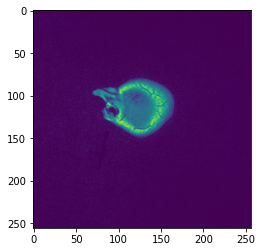

In [6]:
i_have_downloaded_ds000253_R1 = False

if i_have_downloaded_ds000253_R1:
    layout = BIDSLayout("ds000253_R1.0.0")
    test_fdata = layout.get()[4].get_image().get_fdata()
    np.save("ds000253_R1_fdata.npy", test_fdata)
else:
    test_fdata = np.load("ds000253_R1_fdata.npy")

plt.imshow(test_fdata[26])

Tumor image from https://www.nih.gov/news-events/nih-research-matters/subtypes-deadly-brain-cancer-identified

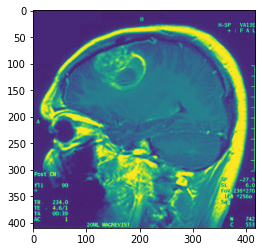

In [7]:
tumor = cv2.cvtColor(cv2.imread("image_before_side.jpg"), cv2.COLOR_BGR2GRAY)
tumor = tumor.astype('float32')
plt.imshow(tumor)

# Making Videos out of MRI + Marching Squares

In [8]:
# loop through first dimension of input_Array,
#  drawing isoline on-each frame for the specified threshold.
def makeVideo(input_array, thresh = 300, scale = 10, outfile = "project.avi", limitFrames = False):
    frames = input_array.shape[0]
    if limitFrames: frames = 10   #debugging parameter
        
    size = (input_array.shape[1]*scale, input_array.shape[2]*scale)

    out = cv2.VideoWriter(outfile, cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
    for i in range(frames):
        out.write( rasterize(test_fdata[i], thresh) )
    out.release()
    return

In [9]:
# Make a series of videos for differing  thresholds
for thresh in range(175, 225, 25):
    filename = "ds253_R1_{0}.avi".format(thresh)
    makeVideo(test_fdata, thresh, 10, filename)

<ipython-input-4-fb292beca3db>:4: RuntimeWarning: invalid value encountered in true_divide
  return (t - v1)/(v2-v1)


In [10]:
# Helper function to write out still images for the tumor example
def makeStills(input_image, thresh, scale, outfile):
    out_im = rasterize(input_image, thresh, scale)
    cv2.imwrite(outfile, out_im)
    return

In [11]:
for thresh in range(100, 210, 10):
    filename = "image_after_side_{0}.jpg".format(thresh)
    makeStills(tumor, thresh, 10, filename)

<ipython-input-4-fb292beca3db>:4: RuntimeWarning: invalid value encountered in true_divide
  return (t - v1)/(v2-v1)
